# Email classifier - A smart routing system for emails

This project aims to create a ML model capable of automatically classifying emails based on their content.
The dataset used is the Enron email dataset, which contains a large number of emails from the Enron Corporation.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

c:\Users\khali\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing Dataset

In [2]:
df = pd.read_csv("./dataset/emails.csv")
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


### EDA

In [3]:
# dataset dimensions
print("Number of rows and columns" , df.shape)
print("Columns:", df.columns.tolist())

# print some messages 
for i in range(3):
    print("="*20)
    print(df['message'].iloc[i][:1000])

Number of rows and columns (517401, 2)
Columns: ['file', 'message']
Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 
Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin

In [4]:
# null values number
print("null values", df.isnull().sum())

null values file       0
message    0
dtype: int64


message
<class 'str'>    517401
Name: count, dtype: int64
0
Messages length statistics:
count    517401
mean       2720
std        8360
min         383
25%         902
50%        1529
75%        2698
max     2011941
Name: message_length, dtype: float64


<Axes: >

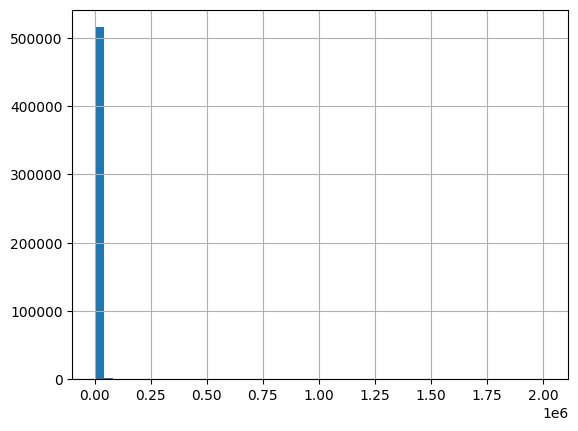

In [5]:
#verify type
print(df['message'].apply(type).value_counts())
print((df['message'].str.strip()=='').sum())
# messages length
df['message'] = df['message'].astype(str)
df['message_length'] = df['message'].str.len()
print("Messages length statistics:")
pd.set_option('display.float_format', '{:.0f}'.format)
print(df['message_length'].describe())
df['message_length'].hist(bins=50)

<Axes: >

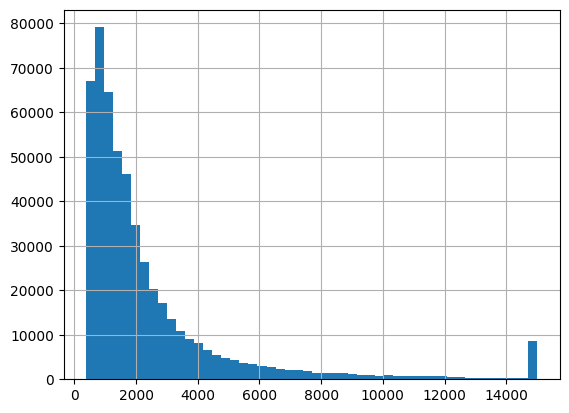

In [6]:
# distribution without extremes
df['message_length'].clip(upper=15000).hist(bins=50)

## Feature Engineering
### Parsing emails

In [7]:
#extracting value from header
def extract_value(line, key):
    if line.lower().startswith(key.lower() + ':'):
        # split the line by colon and return the right part
        return line.split(':', 1)[1].strip()
    return None

# parsing function
def parse_email(email):
    result = {
        'Message-ID': None,
        'Date': None,
        'From': None,
        'To': None,
        'Subject': None,
        'Mime-Version': None,
        'Content-Type': None,
        'Content-Transfer-Encoding': None,
        'X-From': None,
        'X-To': None,
        'X-cc': None,
        'X-bcc': None,
        'X-Folder': None,
        'X-Origin': None,
        'X-FileName': None,
        'body': None
    }
    
    # split headers and body
    parts = email.split('\n\n', 1)
    if len(parts) < 2:
        return result
    headers, body = parts
    result['body'] = body.strip()
    # parse headers
    for line in headers.split('\n'):
        for key in result.keys():
            if result[key] is None:
                # check if the line starts with the key
                extracted_value = extract_value(line, key)
                if extracted_value is not None:
                    # assign the value to the result dictionary
                    result[key] = extracted_value
             
    
    return result

#test parsing
email = df['message'].iloc[0]
parsed_email = parse_email(email)
print("Parsed email:", parsed_email)


Parsed email: {'Message-ID': '<18782981.1075855378110.JavaMail.evans@thyme>', 'Date': 'Mon, 14 May 2001 16:39:00 -0700 (PDT)', 'From': 'phillip.allen@enron.com', 'To': 'tim.belden@enron.com', 'Subject': '', 'Mime-Version': '1.0', 'Content-Type': 'text/plain; charset=us-ascii', 'Content-Transfer-Encoding': '7bit', 'X-From': 'Phillip K Allen', 'X-To': 'Tim Belden <Tim Belden/Enron@EnronXGate>', 'X-cc': '', 'X-bcc': '', 'X-Folder': "\\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail", 'X-Origin': 'Allen-P', 'X-FileName': 'pallen (Non-Privileged).pst', 'body': 'Here is our forecast'}


#### Applying the parser

In [8]:
df_parsed = df['message'].apply(parse_email).apply(pd.Series)
#show head
print("Parsed DataFrame head:")
print(df_parsed.head())

Parsed DataFrame head:
                                      Message-ID  \
0  <18782981.1075855378110.JavaMail.evans@thyme>   
1  <15464986.1075855378456.JavaMail.evans@thyme>   
2  <24216240.1075855687451.JavaMail.evans@thyme>   
3  <13505866.1075863688222.JavaMail.evans@thyme>   
4  <30922949.1075863688243.JavaMail.evans@thyme>   

                                    Date                     From  \
0  Mon, 14 May 2001 16:39:00 -0700 (PDT)  phillip.allen@enron.com   
1   Fri, 4 May 2001 13:51:00 -0700 (PDT)  phillip.allen@enron.com   
2  Wed, 18 Oct 2000 03:00:00 -0700 (PDT)  phillip.allen@enron.com   
3  Mon, 23 Oct 2000 06:13:00 -0700 (PDT)  phillip.allen@enron.com   
4  Thu, 31 Aug 2000 05:07:00 -0700 (PDT)  phillip.allen@enron.com   

                        To    Subject Mime-Version  \
0     tim.belden@enron.com                     1.0   
1  john.lavorato@enron.com        Re:          1.0   
2   leah.arsdall@enron.com   Re: test          1.0   
3    randall.gay@enron.com       

#### Drop unnecessary columns

In [9]:
# Adding From, Subject and body columns to df
df = pd.concat([df, df_parsed[['From', 'Subject', 'body']]], axis=1)
# drop message_length column
df.drop(columns=['message_length'], inplace=True)
# Show the first few rows of the updated DataFrame
print("Updated DataFrame head:")
print(df.head())

Updated DataFrame head:
                       file  \
0     allen-p/_sent_mail/1.   
1    allen-p/_sent_mail/10.   
2   allen-p/_sent_mail/100.   
3  allen-p/_sent_mail/1000.   
4  allen-p/_sent_mail/1001.   

                                             message                     From  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...  phillip.allen@enron.com   
1  Message-ID: <15464986.1075855378456.JavaMail.e...  phillip.allen@enron.com   
2  Message-ID: <24216240.1075855687451.JavaMail.e...  phillip.allen@enron.com   
3  Message-ID: <13505866.1075863688222.JavaMail.e...  phillip.allen@enron.com   
4  Message-ID: <30922949.1075863688243.JavaMail.e...  phillip.allen@enron.com   

     Subject                                               body  
0                                          Here is our forecast  
1        Re:  Traveling to have a business meeting takes the...  
2   Re: test                     test successful.  way to go!!!  
3             Randy,\n\n Can you send 

#### Creating text column to be vectorized

In [10]:
df['text'] = df['From'].fillna('') + ' ' + df['Subject'].fillna('') + ' ' + df['body'].fillna('')


#### Cleaning text with spaCy

In [13]:
import re 
import spacy
nlp = spacy.load("en_core_web_sm")

# Function to clean and tokenize text

def clean_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# testing on small sample 
df_sample = df.sample(1000, random_state=42)

# Apply the cleaning function to the 'text' column
df_sample['cleaned_text'] = df_sample['text'].apply(clean_text)
# Show the first few rows of the DataFrame with cleaned text
print("DataFrame with cleaned text head:")
print(df_sample[['text', 'cleaned_text']].head())

DataFrame with cleaned text head:
                                                     text  \
427616  sara.shackleton@enron.com Re: Credit Derivativ...   
108773  pat.clynes@enron.com Meter #1591 Lamay Gaslift...   
355471  knipe3@msn.com Re: man night again? GCCA Crawf...   
457837  kalmeida@caiso.com Enron 480, 1480 charges <<K...   
124910  chris.germany@enron.com Transport Deal I'm try...   

                                             cleaned_text  
427616  credit derivative bill thank info speak jeff l...  
108773  meter lamay gaslift aimee check meter lamay ga...  
355471  man night gcca crawfish rip raffle price print...  
457837  enron charge chris request charge track date e...  
124910  transport deal try change receipt meter deal m...  


#### Vectorizing text with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_sample['cleaned_text'])
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (1000, 5000)


In [ ]:
# check non-zero values
print("Nombre de valeurs non nulles :", X.nnz)


Nombre de valeurs non nulles : 61959


## Labeling Data

#### adding column label

In [ ]:
df_sample['label'] = ''
df_sample.to_csv('emails_sample_to_label.csv', index=False)
df_excel= pd.read_csv('emails_sample_to_label.csv')
df_excel.to_excel('emails_sample_to_label.xlsx', index=False)

# adding labels in Excel

#### Separating labeled and unlabeled data

In [61]:
df_sample = pd.read_excel('emails_sample_to_label.xlsx')
print("Label count", df_sample['label'].value_counts())
print(df_sample[['file','label']].head())

Label count label
Others        55
Operations    50
Legal         35
Finance       18
Name: count, dtype: int64
                                         file       label
0                     shackleton-s/sent/1912.     Finance
1                    farmer-d/logistics/1066.         NaN
2                  parks-j/deleted_items/202.         NaN
3  stokley-c/chris_stokley/iso/client_rep/41.     Finance
4               germany-c/all_documents/1174.  Operations


In [62]:
df_sample_labeled = df_sample[(df_sample['label'] != '') & df_sample['label'].notna()]
df_sample_unlabeled = df_sample[(df_sample['label'] == '') | df_sample['label'].isna()]




## Training the model on labeled data

### Separating features and labels

In [63]:
X_labeled = df_sample_labeled['cleaned_text']
y_labeled = df_sample_labeled['label']

### Split the data into train and test sets

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled)

### Vectorizing the text data

In [66]:
X_train_clean = X_train.fillna('')
X_test_clean = X_test.fillna('')
X_train_vectorized = vectorizer.transform(X_train_clean)
X_test_vectorized = vectorizer.transform(X_test_clean)



### Training : Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:


c:\Users\khali\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

     Finance       0.00      0.00      0.00         4
       Legal       0.50      0.14      0.22         7
  Operations       0.44      0.40      0.42        10
      Others       0.38      0.73      0.50        11

    accuracy                           0.41        32
   macro avg       0.33      0.32      0.29        32
weighted avg       0.38      0.41      0.35        32



### Training : Naive Bayes

In [68]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)
y_pred_nb = nb_model.predict(X_test_vectorized)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:


c:\Users\khali\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khali\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

     Finance       0.00      0.00      0.00         4
       Legal       0.50      0.14      0.22         7
  Operations       0.50      0.30      0.38        10
      Others       0.38      0.82      0.51        11

    accuracy                           0.41        32
   macro avg       0.34      0.32      0.28        32
weighted avg       0.39      0.41      0.34        32



## Applying the model to unlabeled data

### Vectorizing the text data

In [69]:
X_unlabeled_vectorized = vectorizer.transform(df_sample_unlabeled['cleaned_text'].fillna(''))


### Predicting labels

In [70]:
predicted_labels = nb_model.predict(X_unlabeled_vectorized)

### Adding predicted labels to the unlabeled data

In [71]:
df_sample_unlabeled['predicted_label'] = predicted_labels
df_sample_unlabeled.to_excel('emails_sample_unlabeled_with_predictions.xlsx', index=False)

C:\Users\khali\AppData\Local\Temp\ipykernel_27144\3418782211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_unlabeled['predicted_label'] = predicted_labels
